Testing Visualization Routines

In [7]:
# importing packages
#import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import emission
import astropy
import yt
from yt.units import dimensions
import copy
from scipy.special import voigt_profile
from astropy.cosmology import FlatLambdaCDM
from matplotlib.colors import LogNorm
import sys
import galaxy_visualization

In [8]:
filename = "/Users/bnowicki/Documents/Research/Ricotti/output_00273"
sim_run = filename.split('/')[-1]

# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

wavelengths=[6562.80, 1304.86, 6300.30, 3728.80, 3726.10, 1660.81, 1666.15, \
             4363.21, 4958.91, 5006.84, 1640.41, 1335.66, \
             1906.68, 1908.73, 1549.00, 2795.53, 2802.71, 3868.76, \
             3967.47, 1238.82, 1242.80, 1486.50, 1749.67, 6716.44, 6730.82]

# Ionization Parameter Field
# Based on photon densities in bins 2-4
# Don't include bin 1 -> Lyman Werner non-ionizing
def _ion_param(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c = 2.99792458e10     #light velocity
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']  

# Luminosity field
# Cloudy Intensity obtained assuming height = 1cm
# Return intensity values erg/s/cm**2
# Multiply intensity at each pixel by volume of pixel -> luminosity
def get_luminosity(line):
   def _luminosity(field, data):
      return data['gas', 'intensity_' + line]*data['gas', 'volume']
   return copy.deepcopy(_luminosity)

yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", 
    force_override=True
)

# True divides emissions by density squared in interpolator
dens_normalized = True
if dens_normalized: 
    units = '1/cm**6'
else:
    units = '1'

# Add intensity and luminosity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        #('gas', 'intensity_' + lines[i] + '_[erg_cm^{-2}_s^{-1}]'),
        ('gas', 'intensity_' + lines[i]),
        function=emission.get_line_emission(i, dens_normalized),
        sampling_type='cell',
        units=units,
        force_override=True
    )
    
    yt.add_field(
        ('gas', 'luminosity_' + lines[i]),
        function=get_luminosity(lines[i]),
        sampling_type='cell',
        units='1/cm**3',
        force_override=True
    )

# Load Simulation Data
ds = yt.load(filename)
ad = ds.all_data()

yt : [INFO     ] 2024-12-03 13:16:46,260 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-12-03 13:16:46,261 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-12-03 13:16:46,261 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-03 13:16:46,262 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-03 13:16:46,262 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-03 13:16:46,263 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-12-03 13:16:46,263 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-12-03 13:16:46,263 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-12-03 13:16:46,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-03 13:16:46,264 Parameters: hubble_constant           = 0.674000015258789
yt : [INFO     ] 2024-12-03 13:16:46,270 Detected RAMSES-RT 

In [9]:
center_max=[0.49118094, 0.49275361, 0.49473726]
sp = ds.sphere(center_max, (2000, "pc"))
width = 400

#galaxy_visualization.plot_diagnostics(ds, sp, sim_run, center_max, width)
#galaxy_visualization.plot_intensities(ds, sp, sim_run, center_max, width)
#galaxy_visualization.spectra_driver(ds, ad, sim_run)

In [10]:
luminosities=[]

for line in lines:
    luminosity=ad['gas', 'luminosity_' + line].sum()
    luminosities.append(luminosity.value)

/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:96: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)


In [15]:
directory = sim_run + '_analysis'

if not os.path.exists(directory):
    os.makedirs(directory)

# Save the data to the new directory
file_path = os.path.join(directory, "line_luminosity.txt")
np.savetxt(file_path, luminosities, delimiter=',')

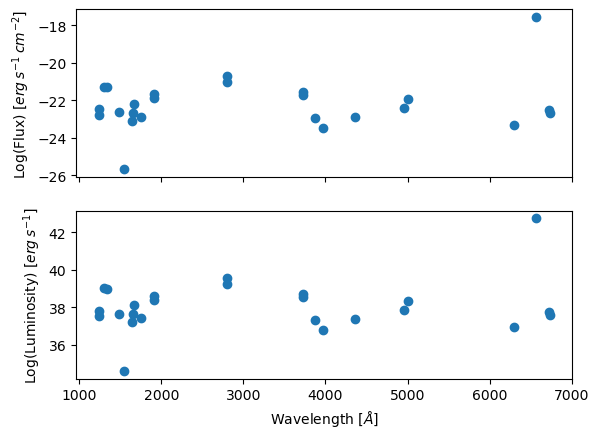

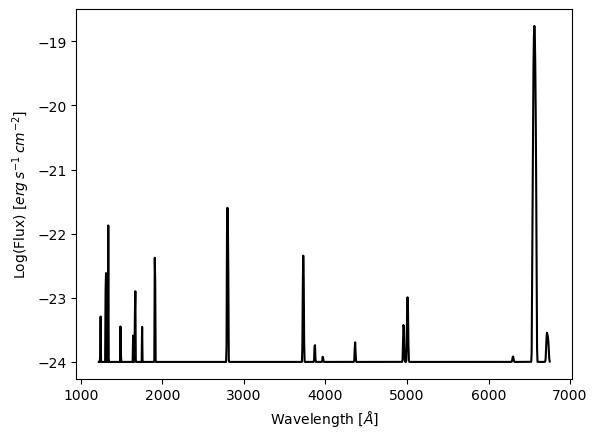

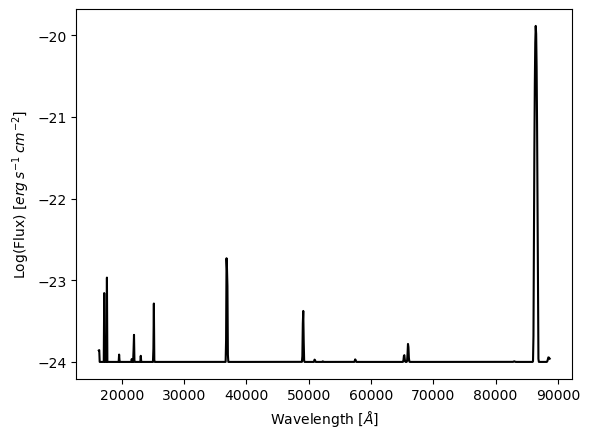

In [17]:
z = ds.current_redshift
omega_matter = ds.omega_matter
omega_lambda = ds.omega_lambda
cosmo = FlatLambdaCDM(H0=70, Om0=omega_matter)#, Om0=0.3)
d_l = cosmo.luminosity_distance(z)*3.086e24 # convert Mpc to cm
flux_arr = luminosities/(4*np.pi*d_l**2)#/100
flux_arr = flux_arr.value

R = 1000

directory = sim_run + '_analysis'

if not os.path.exists(directory):
    os.makedirs(directory)

galaxy_visualization.plot_spectra(wavelengths, luminosities, flux_arr, z, 10e-25, R, fname=os.path.join(directory, "raw_spectra.png"), \
         sim_spectra=False, redshift_wavelengths=False)

galaxy_visualization.plot_spectra(wavelengths, luminosities, flux_arr, z, 10e-25, R, fname=os.path.join(directory, "sim_spectra.png"), \
         sim_spectra=True, redshift_wavelengths=False)

galaxy_visualization.plot_spectra(wavelengths, luminosities, flux_arr, z, 10e-25, R, fname=os.path.join(directory, "sim_spectra_redshifted.png"), \
         sim_spectra=True, redshift_wavelengths=True)

